# Kalman filter for decoding position from population firing rates

Suppose $x_t = \begin{pmatrix} x \\ y \\ v_x \\ v_y \end{pmatrix}$ is the latent state (position and velocity) of the mouse in a 2D envirnment, and $y_t$ is the firing rate of a population of neurons. The Kalman filter can be used to decode the position from the firing rates.

First, we assume that $x_t$ evolves according to a linear dynamical state space model with Gaussian noise:
$$
x_t = A x_{t-1} + w_t, \quad w_t \sim \mathcal{N}(0, Q)$$
where $A$ is the state transition matrix and $Q$ is the process noise covariance matrix. The state transition matrix can be written as:
$$
A = \begin{pmatrix} 1 & 0 & \Delta t & 0 \\ 0 & 1 & 0 & \Delta t \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \end{pmatrix}$$
where $\Delta t$ is the time step.




We assume that the firing rates are related to the latent state by a linear observation model:
$$
y_t = H x_t + v_t, \quad v_t \sim \mathcal{N}(0, R)$$
where $H$ is the observation matrix and $R$ is the observation noise covariance matrix. The observation matrix can be fit to the firing rates of the neurons in the least squares sense:
$$
\min_{H} \sum_{t=1}^T \| y_t - H x_t \|^2$$
where $T$ is the number of time steps. This is a standard linear regression problem, and the solution can be obtained by:
$$
H = \bold{Y}\bold{X}^T(\bold{X}\bold{X}^T)^{-1}$$
where $\bold{Y}$ is the matrix of firing rates and $\bold{X}$ is the matrix of latent states. We also fit the process noise covariance matrix $Q$ and the observation noise covariance matrix $R$ using the minimum mean-square error estimates:
$$
Q = \frac{1}{T} \sum_{t=1}^T (x_t - A x_{t-1})(x_t - A x_{t-1})^T$$
$$
R = \frac{1}{T} \sum_{t=1}^T (y_t - H x_t)(y_t - H x_t)^T$$



Now we will introduce the estimate $\hat{x}_t$ of the latent state at time $t$. We say that $\hat{x}_t$ comes from a similar linear dynamical system:
$$
\hat{x}_t = A \hat{x}_{t-1} + L_t (y_t - H \hat{x}_{t-1})$$
where $L_t (y_t - H \hat{x}_{t-1})$ is feedback proportional to the difference between observed and predicted outputs. We wish to find $\hat{x}_t$ that minimizes the mean squared error:
$$
P_k = \mathbb{E}[(x_t - \hat{x}_t)(x_t - \hat{x}_t)^T]$$
This is a standard Kalman filter problem (Kalman, 1961), and the solution is given by:
$$
L_t = A P_t H^T (R + H P_t C^T H)^{-1}$$
where $P_t$ is defined recursively as:
$$
P_t = (A - L_t C)P_{t-1} (A - L_t C)^T + Q + L_t R L_t^T$$



The Kalman filter can then be used to decode the position from the firing rates in heald out data. We first initialize the state estimate $\hat{x}_0 \sim \mathcal{N}(0, P_0)$, where $P_0$ is the initial state covariance matrix. Following (Malik et al., 2011) we chose $x_0 = 0$ and $P_0 = Q$.



In [1]:
import numpy as np
from decoding_library import *

Loading the neural data

In [ ]:
# specify the kilosorted data directory
kilosort_dir = r"E:\clickbait-ephys\data\kilosorted_data_20um_tetrode\6002\7"

coding_type = 'latency'
fs = 30000 # Hz

if coding_type == 'rate':
    # Parameters for building the spike rate matrix
    window_size = .1 # seconds
    step_size = .1 # seconds
    smoothing_size = 0.5 #bins

    rates_OB, rates_HC, time_bins, units_OB, units_HC = compute_spike_rates_sliding_window_by_region_smooth(kilosort_dir, fs, window_size, step_size, use_units='good/mua', sigma=2.5, zscore=True)
    plot_spike_rates(time_bins, rates_OB, rates_HC, units_OB, units_HC, dark_mode=True, global_font="Arial", show=True, global_font_size=20, normalized = True, cmap = 'Electric')

elif coding_type == 'latency':
    window_size = 30 # samples
    print('Computing spike latencies...')
    spike_latency_matrix_OB, spike_latency_matrix_HC, time_bins, ob_units, hc_units = compute_spike_latency(kilosort_dir, fs, window_size, use_units='good/mua')
    timestamps = np.arange(0, spike_latency_matrix_OB.shape[1], 1)/fs
    print('Normaling spike latencies...')
    normalized_latency_matrix_OB = prepare_latencies_for_kalman(spike_latency_matrix_OB)
    del spike_latency_matrix_OB
    #normalized_latency_matrix_HC = prepare_latencies_for_kalman(spike_latency_matrix_HC)
    #del spike_latency_matrix_HC
print(time_bins[:5])

Computing spike latencies...
Normaling spike latencies...
[0.00000000e+00 3.33333333e-05 6.66666667e-05 1.00000000e-04
 1.33333333e-04]


Loading the events file which contains the tracking

In [3]:
# specifying the behavior directory
behavior_dir = r"E:\clickbait-ephys\data\behavior_data\6002\7"

behavior = load_behavior(behavior_dir)

if coding_type == 'rate':
    data = align_brain_and_behavior(behavior, rates_HC, units_HC, time_bins, window_size, speed_threshold = 3)
elif coding_type == 'latency':
    data = align_brain_and_behavior(behavior, normalized_latency_matrix_HC, hc_units, timestamps, speed_threshold = 3)

Plotting the position over time

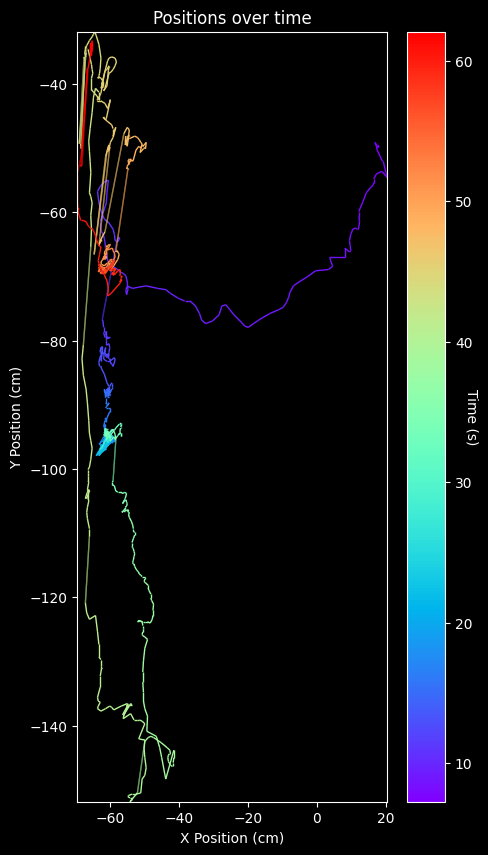

In [4]:
plt.style.use('dark_background')
plot_position_trajectories(data)

Splitting the data into training and test sets

In [ ]:
behavior = data[['x', 'y', 'v_x', 'v_y']].values
spike_rates = data.iloc[:, :-6].values
rates_train, rates_test, switch_ind = cv_split(spike_rates, 2, k_CV=10, n_blocks=10)
behavior_train, behavior_test, _ = cv_split(behavior, 2, k_CV=10, n_blocks=10)
print("Behavior train shape:", behavior_train.shape)

In [ ]:
# Create and train the model
kf = KalmanFilterDecoder(state_dim = behavior_test.shape[1], lambda_reg = 1e-5)
kf.train(behavior_train, rates_train)


# Decode test data
x_est, P = kf.decode(rates_test, switch_indices=switch_ind, gain = 1)

# Plot results
kf.plot_results(x_est, true_behavior=behavior_test, switch_indices=switch_ind)
plt.show()

# Full analysis

In [ ]:
from scipy.stats import ranksums

def process_session(params):

    # Unpack the parameters
    mouse, session, kilosort_dir, behavior_dir, save_dir, window_size, step_size, fs, sigma_smooth, use_units, speed_threshold, k_CV, n_blocks, n_shifts, plot_predictions = params

    try:

        # Load the spike rates and behavior data
        rates_OB, rates_HC, time_bins, units_OB, units_HC = compute_spike_rates_sliding_window_by_region_smooth(kilosort_dir, fs, window_size, step_size, use_units=use_units, sigma=sigma_smooth, zscore=True)
        events = load_behavior(behavior_dir)

        # Looping through the regions
        for region in ['OB', 'HC']:
            if region == 'OB':
                rates = rates_OB
                units = units_OB
            else:
                rates = rates_HC
                units = units_HC
            region_save_path = os.path.join(save_dir, mouse, session, region)
            os.makedirs(region_save_path, exist_ok=True)

            # Aligning the brain and behavior data
            data = align_brain_and_behavior(events, rates, units, time_bins, window_size, speed_threshold = speed_threshold)
            plot_position_trajectories(data, save_path=region_save_path)

            spike_rates = data.iloc[:, :-6].values

            # Unpack the results
            true_rmse = []
            null_rmse = []

            # Loop through the shifts
            for shift in range(n_shifts + 1):
                if shift == 0:
                    behavior = data[['x', 'y', 'v_x', 'v_y']].values
                else:
                    roll_value = np.random.randint(100, len(data) - 100)
                    behavior = data[['x', 'y', 'v_x', 'v_y']].values.copy()
                    behavior = np.roll(behavior, roll_value, axis=0)

                for k in range(k_CV):
                    rates_train, rates_test, switch_ind = cv_split(spike_rates, k, k_CV=k_CV, n_blocks=n_blocks)
                    behavior_train, behavior_test, _ = cv_split(behavior, k, k_CV=k_CV, n_blocks=n_blocks)

                    # Create and train the model
                    kf = KalmanFilterDecoder(state_dim=behavior_test.shape[1], lambda_reg=1e-5)
                    kf.train(behavior_train, rates_train)
                    
                    # Decode test data
                    x_est, P = kf.decode(rates_test, switch_indices=switch_ind, gain=1)

                    # Plot results
                    if plot_predictions:
                        kf.plot_results(x_est, true_behavior=behavior_test, switch_indices=switch_ind)
                        predictions_save_path = os.path.join(region_save_path, "predictions")
                        os.makedirs(predictions_save_path, exist_ok=True)
                        plt.savefig(os.path.join(predictions_save_path, f"shift_{shift}_k_{k}.png"), dpi=300)


                    # Calculate Euclidean distance error at each time point
                    euclidean_distances = np.sqrt(np.sum((x_est[:, :2] - behavior_test[:, :2])**2, axis=1))

                    # Calculate RMSE of these distances
                    rmse = np.sqrt(np.mean(euclidean_distances**2))

                    # Store the MSE
                    if shift == 0:
                        true_rmse.append(rmse)
                    else:
                        null_rmse.append(rmse)

            true_rmse = np.array(true_rmse)
            null_rmse = np.array(null_rmse)

            # rank sum test
            _ , p_val = ranksums(true_rmse, null_rmse, 'less')
            print(f"Rank sum test p-value for {mouse}/{session}: {p_val}")
            
            # plot histograms of the rmse
            plt.figure(figsize=(10, 5))
            plt.hist(true_rmse, bins=10, alpha=0.5, label='True MSE', color='blue', density=True)
            plt.hist(null_rmse, bins=10, alpha=0.5, label='Null MSE', color='red', density=True)
            plt.xlabel('RMSE')
            plt.ylabel('Density')
            plt.title(f'RMSE Distribution for {mouse}/{session}/{region}/p_val: {p_val:.2e}')
            plt.legend()
            plt.savefig(os.path.join(region_save_path, 'mse_distribution.png'), dpi=300)
            plt.close()

            # create a text file to save the p-value
            with open(os.path.join(region_save_path, 'p_value.txt'), 'w') as f:
                f.write(f"Rank sum test p-value: {p_val}\n")

            # save the mse results
            np.save(os.path.join(region_save_path, f"true_rmse.npy"), true_rmse)
            np.save(os.path.join(region_save_path, f"null_rmse.npy"), null_rmse)
        
    except Exception as e:
        print(f"Error processing session {mouse}/{session}: {e}")

In [ ]:
from decoding_library import *
from concurrent.futures import ThreadPoolExecutor, as_completed
import os
import time
import matplotlib
import seaborn as sns
matplotlib.use('Agg')  # Use non-interactive backend to avoid issues in threaded environment

plt.style.use('default')
sns.set_context('poster')





# defining directories
spike_dir = r"E:\clickbait-ephys\data\kilosorted_data_20um_tetrode"
save_dir = r"E:\clickbait-ephys\figures\Kalman_filter (2-27-25)"
events_dir = r"E:\clickbait-ephys\data\behavior_data"


# defining parameters
mice = ['6002', '6003', '6000', '6001', ] # mice to process
sessions = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14'] # sessions to process
fs = 30_000  # Define sampling rate for neural data
sfs = 1_000  # Define sampling rate for sniff
window_size = .1  # Define window size for spike rate computation
step_size = .1  # Define step size for spike rate computation
sigma_smooth = 2.5  # Define smoothing size for spike rate computation
use_units = 'good/mua' # Define units to use for spike rate computation
speed_threshold = 3  # Define speed threshold for behavior data
n_shifts = 10 # Define number of shifts for circular shifting of behavior data
k_CV = 10 # Define number of cross-validation folds
n_blocks = 12 # Define number of blocks for cross-validation
plot_predictions = False
max_workers = 6 # Define number of threads to use for parallel processing


# creating a directory to save the figures
save_dir = os.path.join(save_dir, f"window_size_{window_size}_step_size_{step_size}_sigma_{sigma_smooth}_n_shifts_{n_shifts}")
os.makedirs(save_dir, exist_ok=True)

# saving a textfile with all parameters
with open(os.path.join(save_dir, 'parameters.txt'), 'w') as f:
    f.write(f"window_size: {window_size}\n")
    f.write(f"step_size: {step_size}\n")
    f.write(f"sigma_smooth: {sigma_smooth}\n")
    f.write(f"use_units: {use_units}\n")
    f.write(f"speed_threshold: {speed_threshold}\n")
    f.write(f"n_shifts: {n_shifts}\n")
    f.write(f"k_CV: {k_CV}\n")
    f.write(f"n_blocks: {n_blocks}\n")

def process_session_wrapper(params):
    """
    Wrapper function to catch and handle exceptions from process_session
    """
    mouse, session = params[0], params[1]
    try:
        print(f"Starting processing {mouse}/{session}")
        result = process_session(params)
        return (mouse, session, "Success", result)
    except Exception as e:
        # Log the error and return it with the mouse/session info
        error_msg = f"Error processing {mouse}/{session}: {str(e)}"
        print(error_msg)
        return (mouse, session, "Failed", error_msg)

def run_parallel_processing():
    # Build the task list
    all_tasks = []
    for mouse in mice:
        spike_sessions = os.listdir(os.path.join(spike_dir, mouse))
        for session in spike_sessions:
            if session in sessions:
                # Building the task list
                kilosort_dir = os.path.join(spike_dir, mouse, session)
                behavior_dir = os.path.join(events_dir, mouse, session)
                if not os.path.exists(kilosort_dir) or not os.path.exists(behavior_dir):
                    print(f"Skipping {mouse}/{session} due to missing data.")
                    continue
                params = [mouse, session, kilosort_dir, behavior_dir, save_dir, window_size, step_size, fs, sigma_smooth, use_units, speed_threshold, k_CV, n_blocks, n_shifts, plot_predictions]
                all_tasks.append(params)
    
    print(f"Starting threaded processing with {max_workers} workers for {len(all_tasks)} tasks")
    
    # Create a results log file
    results_log_path = os.path.join(save_dir, 'processing_results.txt')
    with open(results_log_path, 'w') as f:
        f.write(f"Processing started at: {time.strftime('%Y-%m-%d %H:%M:%S')}\n\n")
    
    # Process in parallel with progress bar
    start_time = time.time()
    results = []
    
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Submit all tasks
        future_to_params = {executor.submit(process_session_wrapper, params): params for params in all_tasks}

        for future in as_completed(future_to_params):
            params = future_to_params[future]
            mouse, session = params[0], params[1]
            try:
                result = future.result()
                results.append(result)
                status = result[2]
                # Log individual completion
                with open(results_log_path, 'a') as log_file:
                    log_file.write(f"{mouse}/{session}: {status}\n")
                    if status == "Failed":
                        log_file.write(f"  Error: {result[3]}\n")
                print(f"Completed {mouse}/{session} with status: {status}")
            except Exception as exc:
                print(f"Task for {mouse}/{session} generated an exception: {exc}")
                with open(results_log_path, 'a') as log_file:
                    log_file.write(f"{mouse}/{session}: Exception in executor\n")
                    log_file.write(f"  Error: {str(exc)}\n")
    
    elapsed_time = time.time() - start_time
    
    # Log summary statistics
    success_count = sum(1 for r in results if r[2] == "Success")
    failed_count = sum(1 for r in results if r[2] == "Failed")
    
    with open(results_log_path, 'a') as log_file:
        log_file.write("\n--- SUMMARY ---\n")
        log_file.write(f"Total tasks: {len(all_tasks)}\n")
        log_file.write(f"Successful: {success_count}\n")
        log_file.write(f"Failed: {failed_count}\n")
        log_file.write(f"Total elapsed time: {elapsed_time:.2f} seconds\n")
    
    print(f"Processing complete! Results saved to {results_log_path}")
    print(f"Successful: {success_count}, Failed: {failed_count}")
    print(f"Total elapsed time: {elapsed_time:.2f} seconds")
    
    return results

if __name__ == "__main__":
    results = run_parallel_processing()

In [ ]:
# collect decoding results
import numpy as np
import pandas as pd
from scipy.stats import ranksums
import matplotlib.pyplot as plt
import seaborn as sns
import os

decoding_dir = r"E:\clickbait-ephys\figures\Decoding\Kalman_filter (2-27-25)\window_size_0.1_step_size_0.1_sigma_2.5_n_shifts_10"
mice = ['6002', '6003', '6000', '6001']
regions = ['OB', 'HC']

alpha = 0.05
results = []

for mouse in mice:
    mouse_dir = os.path.join(decoding_dir, mouse)
    sessions = os.listdir(mouse_dir)
    for session in sessions:
        for region in regions:

            null_rmse_file = os.path.join(mouse_dir, session, region, 'null_rmse.npy')
            true_rmse_file = os.path.join(mouse_dir, session, region, 'true_rmse.npy')
            if not os.path.exists(null_rmse_file) or not os.path.exists(true_rmse_file):
                continue
            null_rmse = np.load(null_rmse_file)
            true_rmse = np.load(true_rmse_file)

            # rank sum test
            _ , p_val = ranksums(true_rmse, null_rmse, 'less')
            results.append({'mouse': mouse, 'session': session, 'region': region, 'p_val': p_val})

# convert to dataframe
results = pd.DataFrame(results)

# save the results
results.to_csv(os.path.join(decoding_dir, 'results.csv'), index=False)
print(f'Number of significant sessions: \nHippocampus: {np.sum(results[results.region == "HC"].p_val < alpha)}\nOlfactory Bulb: {np.sum(results[results.region == "OB"].p_val < alpha)}')


# Create a connected points plot
# First, pivot the data to create pairs
# Create a unique identifier for each mouse-session pair
results['mouse_session'] = results['mouse'] + '_' + results['session']

# Create a pivot table where each row is a mouse-session pair and columns are regions
pivot_df = results.pivot(index='mouse_session', columns='region', values='p_val')

# Extract unique mouse-session pairs that have both regions
complete_pairs = pivot_df.dropna().index

# Create a figure
plt.figure(figsize=(10, 6))

# Generate jitter positions for each mouse-session and region
jitter_positions = {}
for idx in complete_pairs:
    jitter_positions[idx] = {}
    for region in regions:
        jitter_positions[idx][region] = np.random.uniform(-0.1, 0.1)

# Plot connections first
for idx in complete_pairs:
    # Get the p-values for both regions for this mouse-session
    ob_pval = pivot_df.loc[idx, 'OB']
    hc_pval = pivot_df.loc[idx, 'HC']
    
    # Get the jittered x-positions
    ob_x = 0 + jitter_positions[idx]['OB']
    hc_x = 1 + jitter_positions[idx]['HC']
    
    # Plot the connecting line
    plt.plot([ob_x, hc_x], [ob_pval, hc_pval], '-', color='gray', alpha=0.5, zorder=1)

# Create a color map for mice
mouse_colors = {mouse: plt.cm.tab10(i) for i, mouse in enumerate(mice)}

# Now plot individual points with mouse-specific colors
for idx in complete_pairs:
    mouse, session = idx.split('_', 1)
    
    # Get the p-values for both regions
    ob_pval = pivot_df.loc[idx, 'OB']
    hc_pval = pivot_df.loc[idx, 'HC']
    
    # Get the jittered x-positions (same as used for the lines)
    ob_x = 0 + jitter_positions[idx]['OB']
    hc_x = 1 + jitter_positions[idx]['HC']
    
    # Plot points for OB
    plt.scatter(ob_x, ob_pval, color=mouse_colors[mouse], 
                label=f'Mouse {mouse}' if idx == complete_pairs[0] or mouse not in [p.split('_')[0] for p in complete_pairs[:complete_pairs.get_loc(idx)]] else "",
                alpha=0.7, s=50, zorder=2)
    
    # Plot points for HC
    plt.scatter(hc_x, hc_pval, color=mouse_colors[mouse], 
                alpha=0.7, s=50, zorder=2)

# Add threshold line
plt.axhline(y=alpha, color='r', linestyle='--', label=f'α = {alpha}')

# Label and customize
plt.xticks([0, 1], ['OB', 'HC'])
plt.ylabel('p-value')
plt.title('Paired p-values for decoding results by region')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(decoding_dir, 'paired_p_values_jittered.png'), dpi=300)
plt.show()

# Create an additional plot showing average by mouse
plt.figure(figsize=(10, 6))

# Group by mouse and region to get average p-values
mouse_avg = results.groupby(['mouse', 'region'])['p_val'].median().reset_index()
mouse_avg_pivot = mouse_avg.pivot(index='mouse', columns='region', values='p_val')

# Plot average lines for each mouse
for mouse in mice:
    if mouse in mouse_avg_pivot.index and not mouse_avg_pivot.loc[mouse].isna().any():
        plt.plot([0, 1], 
                 [mouse_avg_pivot.loc[mouse, 'OB'], mouse_avg_pivot.loc[mouse, 'HC']], 
                 'o-', label=f'Mouse {mouse}', 
                 color=mouse_colors[mouse], 
                 linewidth=2, 
                 markersize=8)

# Add threshold line
plt.axhline(y=alpha, color='r', linestyle='--', label=f'α = {alpha}')

# Label and customize
plt.xticks([0, 1], ['OB', 'HC'])
plt.ylabel('Median p-value')
plt.title('Median p-values by mouse and region')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(decoding_dir, 'avg_p_values_by_mouse.png'), dpi=300)
plt.show()

